In [8]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
%matplotlib inline

import scipy.io
from scipy.stats import multivariate_normal as mvn

import numpy as np
import numpy.matlib

import math
import pandas as pd
import statistics
import scipy.sparse.linalg as ll
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D

## load matlab file
mat = scipy.io.loadmat('data/data.mat')
data = np.array((mat.get('data')).T)

label_mat = scipy.io.loadmat('data/label.mat')
label = np.array(label_mat['trueLabel'])

## import files
# xtrain = mat.get('xtrain') / 255
# ytrain = mat.get('ytrain')


In [2]:
## from lecture code

mean0 = np.mean(data, axis = 0, keepdims = True)
ndata = data -mean0

m, n = ndata.shape
C = np.matmul(ndata.T, ndata)/m

# pca the data
d = 4  # reduced dimension
U, S,_ = np.linalg.svd(C)
ind = U[:,:d]
S = np.diag(S[:d])

# project the data to the top 4 principal directions
pdata = np.dot(ndata, ind)

# plt.scatter(pdata[np.where(label == 2),0],pdata[np.where(label == 2),1])
# plt.scatter(pdata[np.where(label == 6),0],pdata[np.where(label == 6),1])
# plt.show()

In [3]:
# EM-GMM for MNIST
# number of responses
K = 2

# random seed
seed = 5
np.random.seed(seed)

# initialize prior
pi = np.random.random(K)
pi = pi/np.sum(pi)

# initial mean and covariance
# np.random.seed(seed)
mu = np.random.randn(K,d)
mu_old = mu.copy()

#Covariance Matrix
sigma = []
for ii in range(K):
    # to ensure the covariance psd
    np.random.seed(seed)
    dummy = np.random.randn(d, d)
    sigma.append(dummy@dummy.T+np.eye(d))

In [4]:
# initialize the posterior
tau = np.full((m, K), fill_value=0.)

# initialize
maxIter= 100
tol = 1e-3

#
log_likelihood = []
iterations = []

for ii in range(100):

    # E-step    
    for kk in range(K):
        tau[:, kk] = pi[kk] * mvn.pdf(pdata, mu[kk], sigma[kk])
        #print(tau)
    # normalize tau
    sum_tau = np.sum(tau, axis=1)
    sum_tau.shape = (m,1)  
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
    log_likelihood.append(np.sum(np.log(sum_tau)))

    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk])/m
        
        # update component mean
        mu[kk] = pdata.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
        
        # update cov matrix
        dummy = pdata - np.tile(mu[kk], (m,1)) # X-mu
        sigma[kk] = dummy.T @ np.diag(tau[:,kk]) @ dummy / np.sum(tau[:,kk], axis = 0)
        
#     print('-----iteration---',ii)    
    if np.linalg.norm(mu-mu_old) < tol:
        print('training coverged')
        break
    mu_old = mu.copy()
    if ii==99:
        print('max iteration reached')
        break

training coverged


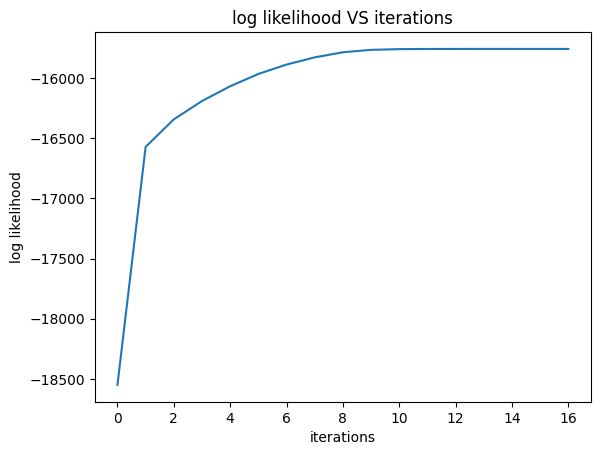

In [5]:
plt.figure()
plt.plot(log_likelihood,)
plt.title('log likelihood VS iterations')
plt.ylabel('log likelihood')
plt.xlabel('iterations')
plt.savefig('images/Q3/log_likelihood')
plt.show()


b) means and covariances

In [14]:
print(mu, pi)

[[ 1.99406066  0.574035    0.11348088 -0.02367806]
 [-2.10051702 -0.60468085 -0.11953926  0.02494215]] [0.51299968 0.48700032]


In [6]:
mu #mean
pi #weights

means1 = (ind @ mu[0] + mean0).reshape(28,28).T
plt.imsave(('images/Q3/mean1.png'),means1, cmap = 'gray')

means2 = (ind @ mu[1] + mean0).reshape(28,28).T
plt.imsave(('images/Q3/mean2.png'),means2, cmap = 'gray')


<Axes: >

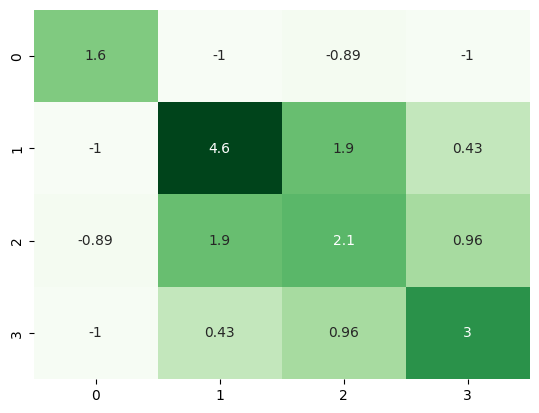

In [22]:
#https://python-graph-gallery.com/heatmap/#
import seaborn as sns

# 6
#sns.heatmap(sigma[0], cmap = cm['Greens'], annot=True, cbar = False)

# 2
sns.heatmap(sigma[1], cmap = cm['Greens'], annot=True, cbar = False)

In [10]:
#misclassification rate = (no false negatives)/(total) 

label_gmm = np.argmax(tau, axis =1)
label_gmm[label_gmm==0]=6
label_gmm[label_gmm==1]=2

## for 2's
label_2 = label[label==2]
label_2gmm = label_gmm[(label==2)[0,:]]
print(sum(label_2gmm!=label_2)/len(label_2)*100)

## for 6's
label_6 = label[label==6]
label_6gmm = label_gmm[(label==6)[0,:]]
print(sum(label_6gmm!=label_6)/len(label_6)*100)

6.492248062015504
0.9394572025052191


In [13]:
##missclassification rate knn
from sklearn.cluster import KMeans

kmeans_raw = KMeans(n_clusters=2).fit(pdata)
kmeans = kmeans_raw.labels_
kmeans[kmeans==0]=6
kmeans[kmeans==1]=2

## for 2's
label_2 = label[label==2]
label_2k = kmeans[(label==2)[0,:]]
print(sum(label_2k!=label_2)/len(label_2)*100)

## for 6's
label_6 = label[label==6]
label_6k = kmeans[(label==6)[0,:]]
print(sum(label_6k!=label_6)/len(label_6)*100)

6.104651162790697
7.933194154488518
